# Emotions Dataset For NLP

## About Dataset
Context
Collection of documents and its emotions, It helps greatly in NLP Classification tasks

## Content
List of documents with emotion flag, Dataset is split into train, test & validation for building the machine learning model

## Example
i feel like I am still looking at a blank canvas blank pieces of paper;sadness

## Acknowledgements
Elvis Saravia, Hsien-Chi Toby Liu, Yen-Hao Huang, Junlin Wu, and Yi-Shin Chen. 2018. CARER: Contextualized Affect Representations for Emotion Recognition. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, pages 3687–3697, Brussels, Belgium. Association for Computational Linguistics.

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=val.txt

In [1]:
!pip install contractions

In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
import nltk
import contractions

from functools import partial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

In [5]:
def open_txt(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
        lines = [line.replace("\n", "") for line in lines]

    df = pd.DataFrame(lines, columns=["emotions"])
    df['emotions'] = df['emotions'].str.split(';')

    return pd.DataFrame(df["emotions"].to_list(), columns=['text', 'emotion'])


In [6]:
df_train = open_txt("train/train.txt")
df_val = open_txt("val/val.txt")
df_test = open_txt("test/test.txt")

In [7]:
# Concat Train and Validation Dataset because of StratifiedKfold
df_train = pd.concat([df_train, df_val])

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     18000 non-null  object
 1   emotion  18000 non-null  object
dtypes: object(2)
memory usage: 421.9+ KB


In [9]:
df_train.emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [10]:
df_train.sample(10)

,text,emotion
15691,im feeling very sentimental tonight,sadness
1898,i was back in my hometown feeling unhappy in n...,sadness
15285,i feel strongly impressed that there must be s...,surprise
1885,i feel happy about myself hes the reason why i...,joy
4034,i feel pleased about this issue there are a lo...,joy
10866,i get the feeling that the relationship would ...,anger
6113,i like the phrase having submissive feelings t...,sadness
6223,i feel that branding in college is way more po...,joy
13713,i don t feel the least bit regretful about it,sadness
92,when my mums brother passed away after having ...,sadness


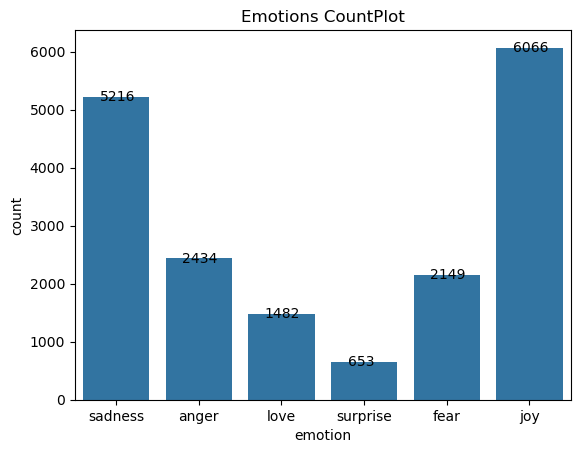

In [11]:
fig, ax = plt.subplots()
ax.set_title("Emotions CountPlot")
countplot = sns.countplot(data=df_train, x="emotion", ax=ax)

for p in ax.patches:
    countplot.annotate(f"{int(p.get_height())}", xy=(p.get_x()+0.2, p.get_height()), verticalalignment="center")
plt.show()

# Format Text

In [12]:
def format_text(text):
    custom_list = ["im"]
    stopwords = nltk.corpus.stopwords.words("english")
    stopwords.remove("not")
 
    custom_list = ["im"]
    formatted_text = str(text)
    formatted_text = contractions.fix(formatted_text)
    formatted_text = nltk.tokenize.word_tokenize(formatted_text)

    formatted_text = [
        word for word in formatted_text if word.lower() not in stopwords
        and word.lower() not in custom_list]
    
    formatted_text = ' '.join(formatted_text)

    return formatted_text.lower().strip()

In [13]:
df_train["formatted_text"] = df_train.text.apply(format_text)

In [389]:
df_train.sample(5)

,text,emotion,formatted_text
2823,i was feeling as if i am in the lap of the div...,joy,feeling lap divine mother holding soft tender ...
357,i feel envious and embarrassed,anger,feel envious embarrassed
1683,i had applied for a job and they had assured m...,anger,applied job assured exams would take place mon...
11827,i cry at the feeling of the suffering of manki...,sadness,cry feeling suffering mankind let go let pain ...
464,i always feel like ive been assaulted by his pics,sadness,always feel like assaulted pics


In [14]:
X = tf.convert_to_tensor(df_train.formatted_text, dtype=tf.string)
y = tf.convert_to_tensor(df_train.emotion, dtype=tf.string)

In [15]:
y_int = tf.identity(y) #return same tensor

In [16]:
string_lookup_layer = tf.keras.layers.StringLookup(
    max_tokens=None,
    num_oov_indices=1,
    mask_token=None,
    oov_token='[UNK]',
    vocabulary=None,
    idf_weights=None,
    invert=False,
    output_mode='int',
    name="string_lookup_layer"
)

In [17]:
string_lookup_layer.adapt(y_int)
y_int = string_lookup_layer(y_int)

# MLP

In [18]:
def build_up_model(hidden_layers_list, text_vectorization_layer, lr=float, vocab_size=20000, embedding_dim=16):

    model = tf.keras.models.Sequential(name="sequential_model")
    model.add(text_vectorization_layer)   
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
    for attribute in hidden_layers_list:
        if isinstance(attribute, int):
            model.add(tf.keras.layers.Dense(attribute, activation="relu"))
        else:
            model.add(tf.keras.layers.Dropout(attribute))
    
    model.add(tf.keras.layers.Dense(6, activation="softmax")) # 6 class

    model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

    return model

In [19]:
skf = StratifiedKFold(n_splits=5)

In [20]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [10, 25]
hidden_layers_list = [(64, 32), (64, 0.2, 32)]

param_grid = list(itertools.product(hidden_layers_list, learning_rates, batch_sizes, epochs_list))

In [21]:
parameters = []
accuracies = []

In [22]:
vocab_size = 10000
embedding_dim = 100
sequence_length = 50

In [ ]:
for params in param_grid:

    hidden_layers, lr, batch_size, epoch = params
    parameters.append(params)

    current_param_accuracies = []

    for train_idx, val_idx in skf.split(X, y_int): # y_int needed because of stratified fold
        
        X_train, y_train = tf.gather(X, train_idx), tf.gather(y, train_idx)
        X_val, y_val = tf.gather(X, val_idx), tf.gather(y, val_idx)

        string_lookup_layer = tf.keras.layers.StringLookup(
            num_oov_indices=0, # set to 0, because if it is 1 then 7 class will be at the softmax!
            oov_token='[UNK]',
            output_mode='int',
            name="string_lookup_layer"
        )

        string_lookup_layer.adapt(y_train)
        y_train, y_val = string_lookup_layer(y_train), string_lookup_layer(y_val)
        vocab = string_lookup_layer.get_vocabulary()

        text_vectorization_layer = tf.keras.layers.TextVectorization(
            standardize='lower_and_strip_punctuation',
            max_tokens=vocab_size,
            output_sequence_length=sequence_length,
            output_mode='int',
            name="text_vectorizer_layer",

        )
        text_vectorization_layer.adapt(X_train)

        model = build_up_model(hidden_layers, text_vectorization_layer, lr=lr, vocab_size=vocab_size, embedding_dim=embedding_dim)

        history = model.fit(
            X_train,
            y_train,
            epochs=epoch,
            batch_size=batch_size,
            validation_data=(X_val, y_val)
        )

        predictions = model.predict(X_val)

        predicted_labels = tf.cast(tf.argmax(predictions, axis=1), tf.float16)

        current_param_accuracies.append(accuracy_score(y_val, predicted_labels))

        del model, string_lookup_layer, text_vectorization_layer
        K.clear_session()
    
    mean_accuracy = np.mean(current_param_accuracies)
    accuracies.append(mean_accuracy)

In [26]:
parameters[np.argmax(np.array(accuracies))]

((64, 0.2, 32), 0.001, 32, 10)

In [27]:
accuracies[np.argmax(np.array(accuracies))]

0.857

In [28]:
best_parameters = ((64, 0.2, 32), 0.001, 32, 10)

## Best Params Test

In [29]:
vocab_size = 10000
embedding_dim = 100
sequence_length = 50

In [30]:
train_ds, val_ds, train_labels, val_labels = train_test_split(X.numpy(), y.numpy(), test_size=0.2, stratify=y_int.numpy(), random_state=42)

In [31]:
train_ds, train_labels =  tf.convert_to_tensor(train_ds),  tf.convert_to_tensor(train_labels)
val_ds, val_labels = tf.convert_to_tensor(val_ds),  tf.convert_to_tensor(val_labels)

In [32]:
string_lookup_layer = tf.keras.layers.StringLookup(
    num_oov_indices=0, # set to 0, because if it is 1 then 7 class will be at the softmax!
    oov_token='[UNK]',
    output_mode='int',
    name="string_lookup_layer"
)

In [33]:
string_lookup_layer.adapt(train_labels)
train_labels, val_labels = string_lookup_layer(train_labels), string_lookup_layer(val_labels)
vocab = string_lookup_layer.get_vocabulary()

In [34]:
text_vectorization_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    output_mode='int',
    name="text_vectorizer_layer",
)

text_vectorization_layer.adapt(train_ds)

In [35]:
hidden_layers, lr, batch_size, epoch = best_parameters

In [40]:
model = build_up_model(hidden_layers, text_vectorization_layer, lr=lr, vocab_size=vocab_size, embedding_dim=embedding_dim)

history = model.fit(
    train_ds,
    train_labels,
    epochs=epoch,
    batch_size=batch_size,
    validation_data=(val_ds, val_labels)
)

Epoch 1/10
450/450 [==============================] - 5s 8ms/step - loss: 1.5765 - accuracy: 0.3342 - val_loss: 1.5150 - val_accuracy: 0.3378
Epoch 2/10
450/450 [==============================] - 4s 9ms/step - loss: 0.9906 - accuracy: 0.6240 - val_loss: 0.6880 - val_accuracy: 0.7561
Epoch 3/10
450/450 [==============================] - 3s 8ms/step - loss: 0.4279 - accuracy: 0.8551 - val_loss: 0.4763 - val_accuracy: 0.8450
Epoch 4/10
450/450 [==============================] - 3s 8ms/step - loss: 0.2325 - accuracy: 0.9281 - val_loss: 0.4025 - val_accuracy: 0.8669
Epoch 5/10
450/450 [==============================] - 4s 8ms/step - loss: 0.1634 - accuracy: 0.9510 - val_loss: 0.4148 - val_accuracy: 0.8744
Epoch 6/10
450/450 [==============================] - 3s 7ms/step - loss: 0.1208 - accuracy: 0.9622 - val_loss: 0.5138 - val_accuracy: 0.8592
Epoch 7/10
450/450 [==============================] - 3s 7ms/step - loss: 0.0962 - accuracy: 0.9716 - val_loss: 0.4555 - val_accuracy: 0.8692
Epoch 

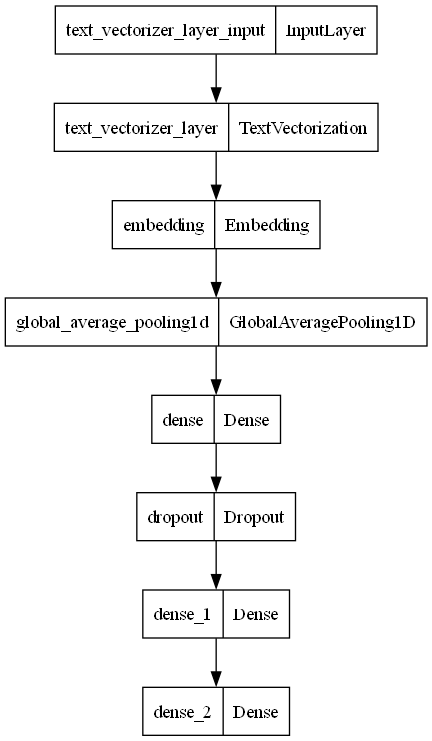

In [41]:
tf.keras.utils.plot_model(model)

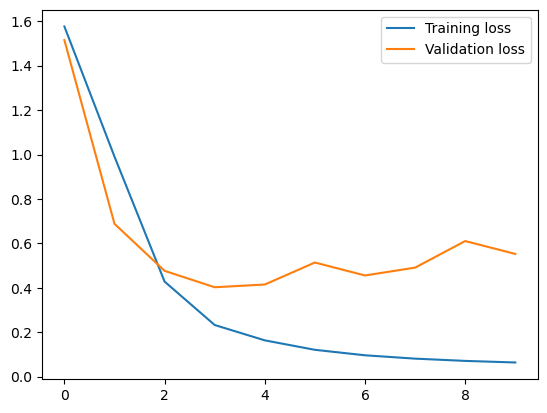

In [42]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [43]:
predictions = model.predict(val_ds)
predicted_labels = tf.cast(tf.argmax(predictions, axis=1), tf.float16)

113/113 [==============================] - 0s 3ms/step


In [44]:
embedding_weights = model.get_layer('embedding').get_weights()[0]
text_vect_vocab = text_vectorization_layer.get_vocabulary()

In [45]:
out_v = open('vectors.tsv', 'w', encoding='utf-8')
out_m = open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(text_vect_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedding_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [46]:
predicted_labels

<tf.Tensor: shape=(3600,), dtype=float16, numpy=array([0., 0., 0., ..., 0., 2., 0.], dtype=float16)>

In [47]:
val_labels

<tf.Tensor: shape=(3600,), dtype=int64, numpy=array([4, 5, 0, ..., 0, 2, 0], dtype=int64)>

In [48]:
cm = confusion_matrix(val_labels, predicted_labels)
accuracy = accuracy_score(val_labels, predicted_labels)

In [49]:
decoder = tf.keras.layers.StringLookup(
        vocabulary=vocab,
        invert=True,
    )

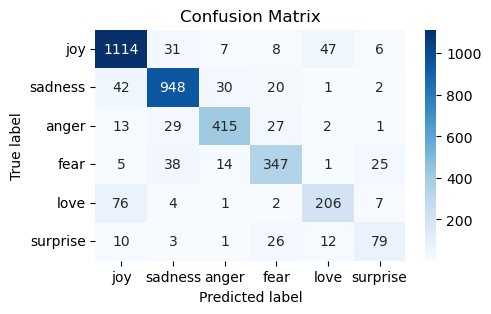

Validation Accuracy: 0.8636


In [50]:
class_labels = decoder([1, 2, 3, 4, 5, 6]).numpy().astype(str)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [51]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 6

for i in range(output_nodes):
    print(f"Class {class_labels[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class joy:
  Precision: 0.8841
  Recall: 0.9184
  F1-score: 0.9009
Class sadness:
  Precision: 0.9003
  Recall: 0.9089
  F1-score: 0.9046
Class anger:
  Precision: 0.8868
  Recall: 0.8522
  F1-score: 0.8691
Class fear:
  Precision: 0.8070
  Recall: 0.8070
  F1-score: 0.8070
Class love:
  Precision: 0.7658
  Recall: 0.6959
  F1-score: 0.7292
Class surprise:
  Precision: 0.6583
  Recall: 0.6031
  F1-score: 0.6295

Macro-average F1-score: 0.8067


In [52]:
accurate_predictions_mask = tf.equal(val_labels, tf.cast(predicted_labels, tf.int64))

In [80]:
for i in range(10):
    random_idx = np.random.choice(np.where(accurate_predictions_mask.numpy() == True)[0])
    print(f"{val_ds[random_idx].numpy().decode('utf-8')} | Actual label: {decoder(val_labels[random_idx].numpy()+1).numpy().decode('utf-8')} | Predicted Label: {decoder(predicted_labels[random_idx].numpy()+1).numpy().decode('utf-8')}")

wanted avoid feeling rushed | Actual label: anger | Predicted Label: anger
feeling little bit melancholy tonight | Actual label: sadness | Predicted Label: sadness
not feel threatened | Actual label: fear | Predicted Label: fear
feel really disgusted pain agony | Actual label: anger | Predicted Label: anger
feeling one calmer states past month pleasant | Actual label: joy | Predicted Label: joy
seeing sausage made rather feeling appalled broadening understanding makes good book | Actual label: anger | Predicted Label: anger
spent wednesday feeling miserable | Actual label: sadness | Predicted Label: sadness
got sick feeling stomach blog post cute laundry room dryers going | Actual label: joy | Predicted Label: joy
feel write truly innocent even though quite bit feeling involved | Actual label: joy | Predicted Label: joy
feel troubled ongoing relocation front door | Actual label: sadness | Predicted Label: sadness
